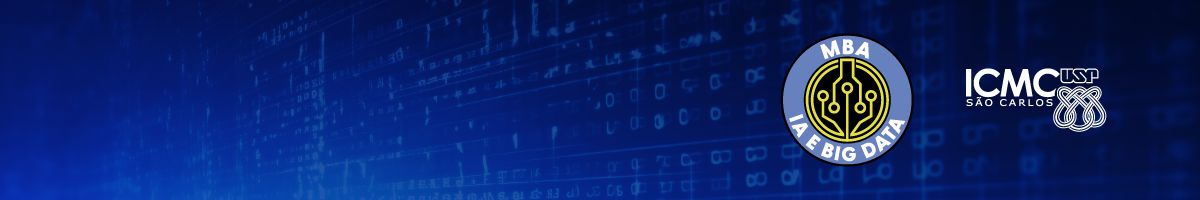

In [1]:
# %pip install numpy==1.26.4

### Reiniciar sessão após executar código acima

In [2]:
import numpy as np
print(np.__version__) # deve exibir versão 1.26.4

1.26.4


In [3]:
# ! wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
# ! tar -xvzf ml-20m-compact.tar.gz

In [4]:
%pip install fastFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.6 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-4amm46he/fastfm_7d409e92d0cb4eee8e6de5782a83afbe/setup.py", line 3, in <module>
          from Cython.Distutils import build_ext
      ModuleNotFoundError: No module named 'Cython'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to us

In [5]:
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from fastFM import sgd

ModuleNotFoundError: No module named 'fastFM'

In [ ]:
ratings = pd.read_csv('./dataset/ratings_sample.csv')
ratings.head()

In [ ]:
movies = pd.read_csv('./dataset/movies_sample.csv')
# Separando gêneros em colunas One-Hot
movies_expanded = movies["genres"].str.get_dummies(sep="|")
# Juntar com os IDs dos filmes
movies = pd.concat([movies[["movieId", "title"]], movies_expanded], axis=1)
movies.head()

In [ ]:
movies.shape

In [ ]:
# Remover colunas desnecessárias
ratings.drop(columns=["timestamp"], inplace=True)
ratings.head()

In [ ]:
# Normalizar IDs para índices consecutivos
ratings["userId"] = ratings["userId"].astype("category").cat.codes
ratings["movieId"] = ratings["movieId"].astype("category").cat.codes
movies["movieId"] = movies["movieId"].astype("category").cat.codes

In [ ]:
print(ratings.shape) # (qtde_interações, qtde_colunas)
print(movies.shape) # (qtde_filmes_diferentes_total, qtde_generos + 2 colunas (movieId e title))
print(max(ratings["userId"])+1) # qtde_usuários
print(max(movies["movieId"])+1) # qtde_filmes_diferentes_total
print(max(ratings["movieId"])+1) # qtde_filmes_diferentes_interagidos

In [ ]:
# Unir as avaliações com os gêneros dos filmes
df = ratings.merge(movies, on="movieId")
df.head()

In [ ]:
df.shape

In [ ]:
# Codificação One-Hot para Usuários e Filmes
encoder = OneHotEncoder(handle_unknown="ignore")
X_users_movies = encoder.fit_transform(df[["userId", "movieId"]])  # Matriz esparsa para usuários e filmes
X_users_movies # Formato: (qtde_interações, qtde_usuarios + qtde_filmes_diferentes_interagidos)

In [ ]:
# Criar matriz esparsa de gêneros
X_genres = csr_matrix(df.iloc[:, 4:].values)  # Gêneros estão na posição 4 em diante
X_genres # Formato: (qtde_interações, qtde_generos)

In [ ]:
# Concatenar usuários, filmes e gêneros
X = hstack([X_users_movies, X_genres])  # Matriz final combinada
y = df["rating"].values  # Variável alvo (notas dos filmes)
print(X.shape)
print(y.shape)

In [ ]:
# Salva os índices verdadeiros do DataFrame
df_indices = df.index.to_numpy()

# Divide os índices
train_idx, test_idx = train_test_split(df_indices, test_size=0.2, random_state=42)

# Agora usa esses índices para dividir X e y corretamente
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
# Treinando o modelo Factorization Machines
fm = sgd.FMRegression(n_iter=10000, init_stdev=0.1, rank=10, step_size=0.01)
fm.fit(X_train, y_train)

In [ ]:
# Fazendo previsões no conjunto de teste
y_pred = fm.predict(X_test)

In [ ]:
# Calculando erro (RMSE - Root Mean Squared Error)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")

## Usando Factorization Machines para ranqueamento

In [ ]:
# Criar rótulos binários (1 = relevante, -1 = irrelevante)
y_train_binary = np.where(y_train >= 4, 1, -1)
y_test_binary = np.where(y_test >= 4, 1, -1) # Para prever no teste

In [ ]:
# Treinar o modelo FM para classificação
fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, rank=10, step_size=0.01)
fm.fit(X_train, y_train_binary)

In [ ]:
# Agora rodar predict_proba() apenas nas linhas não vazias
y_pred_proba = fm.predict_proba(X_test)

# Obter os userId e movieId corretos usando os índices do conjunto de teste
user_ids_test = df.iloc[test_idx]["userId"].values
movie_ids_test = df.iloc[test_idx]["movieId"].values

In [ ]:
print(user_ids_test)
print(movie_ids_test)

In [ ]:
# Criar DataFrame de recomendações com usuários e filmes
recommendations = pd.DataFrame({
    "user_id": user_ids_test,  # Adicionando user_id
    "movie_id": movie_ids_test,
    "relevance_score": y_pred_proba
})

recommendations.head(20)

In [ ]:
# Ordenar por usuário e score de relevância (descendente)
recommendations = recommendations.sort_values(by=["user_id", "relevance_score"], ascending=[True, False])

# Selecionar as 5 principais recomendações para cada usuário
top_5_recommendations = recommendations.groupby("user_id").head(5)

# Exibir os top 5 recomendados para cada usuário
top_5_recommendations.head(20)  # Mostra alguns exemplos